/tmp/ipython-input-1530698265.py:26: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-1530698265.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-1530698265.py:26: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s

NameError: name 'OUT_DIR' is not defined

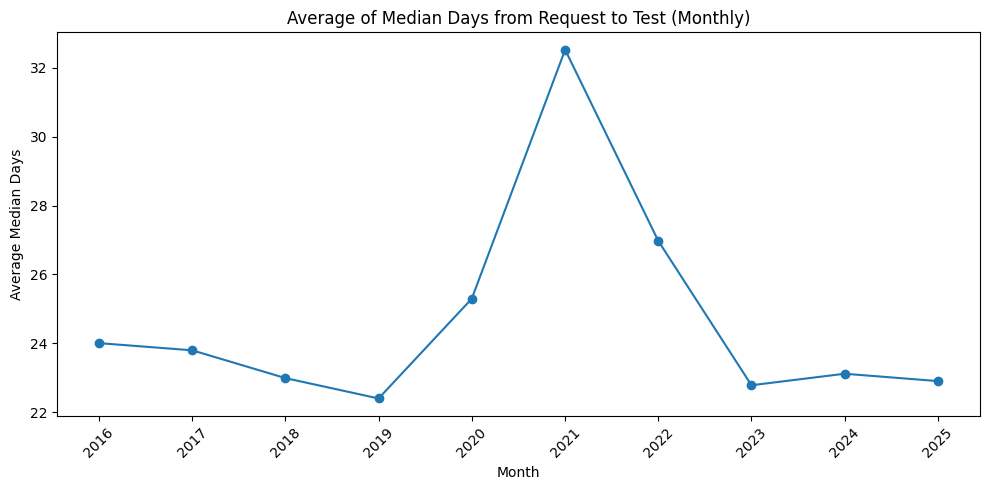

In [5]:
# === RequestToTest: monthly average + region mapping ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

'''# ---------- CONFIG ----------
CSV_PATH = Path("/content/RequestToTest.csv")  # change if needed
OUT_DIR = Path("/content")
OUT_DIR.mkdir(parents=True, exist_ok=True)
'''
# ---------- LOAD ----------
df_raw = pd.read_csv("RequestToTest.csv")

# Standardize column names
df = df_raw.rename(columns=lambda x: x.strip().replace(" ", "_").lower()).copy()

# Likely columns (adjust if your names differ)
# Look for provider/region, and the numeric "median days" column
provider_col = next((c for c in df.columns if c in ["provider_name","provider","trust","organisation","organization","org_name"]), None)
region_name_col = next((c for c in df.columns if c in ["region_name","regionname","region_full_name","region_full"]), None)
region_code_col = next((c for c in df.columns if c in ["region","region_code","nhs_region_code"]), None)

# Try to detect a date-like column
def try_parse_date(series):
    return pd.to_datetime(series, errors="coerce", infer_datetime_format=True)

date_col = None
parsed_date = None
best_cov = -1
for c in df.columns:
    if pd.api.types.is_numeric_dtype(df[c]):
        continue
    p = try_parse_date(df[c])
    if p.notna().mean() > best_cov and p.nunique(dropna=True) >= 3:
        best_cov = p.notna().mean()
        parsed_date = p
        date_col = c

# Fallback: Year+Month construction
if parsed_date is None or parsed_date.notna().sum() < 3:
    year_cand = next((c for c in df.columns if c in ["year","yr"]), None)
    month_cand = next((c for c in df.columns if c in ["month","mnth","mo"]), None)
    if year_cand and month_cand:
        y = pd.to_numeric(df[year_cand], errors="coerce")
        m_raw = df[month_cand].astype(str)
        # handle numeric or text months
        m = pd.to_numeric(m_raw, errors="coerce")
        if m.isna().all():
            m = pd.to_datetime("01-" + m_raw, errors="coerce").dt.month
        parsed_date = pd.to_datetime(dict(year=y, month=m, day=1), errors="coerce")
        date_col = f"{year_cand}_{month_cand}"

if parsed_date is None or parsed_date.notna().sum() < 3:
    raise ValueError("Could not detect a usable date column. Add a Date or Year+Month.")

df["__date__"] = parsed_date

# Detect numeric "median days" column
def score_val(name, s):
    n = name.lower()
    sc = 0
    if "median" in n or "med" in n: sc += 2
    if "day" in n or "days" in n or "request_to_test" in n or "d2d" in n: sc += 2
    sc += min(s.nunique(), 5)*0.1
    return sc

value_candidates = []
for c in df.columns:
    if c == "__date__":
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        value_candidates.append(c)
    else:
        coerced = pd.to_numeric(df[c], errors="coerce")
        if coerced.notna().mean() > 0.8:
            df[c] = coerced
            value_candidates.append(c)

if not value_candidates:
    raise ValueError("No numeric column found for the median-days metric.")

best_val_col = max(value_candidates, key=lambda c: score_val(c, df[c]))

# Build tidy
tidy = df.loc[:, ["__date__", best_val_col]].rename(columns={"__date__":"date", best_val_col:"median_days"})
tidy = tidy.dropna(subset=["date","median_days"]).sort_values("date")

# ----- Monthly average line chart -----
monthly_avg = tidy.assign(year_month=tidy["date"].dt.to_period("M").dt.to_timestamp())
monthly_avg = monthly_avg.groupby("year_month")["median_days"].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(monthly_avg["year_month"], monthly_avg["median_days"], marker="o")
plt.title("Average of Median Days from Request to Test (Monthly)")
plt.xlabel("Month")
plt.ylabel("Average Median Days")
plt.xticks(rotation=45)
plt.tight_layout()
out_monthly_png = OUT_DIR / "request_to_test_monthly_avg.png"
plt.savefig(out_monthly_png, dpi=200, bbox_inches="tight")
plt.close()

# ----- Fill missing region names using provider -> region name map -----
# Try to build map only if we have provider and a region-name column
avg_per_region = None
if provider_col:
    # If region name column is missing, create it from codes (as a copy) to fill later
    if not region_name_col:
        # if only a region code exists, start with that (we’ll try to replace some via mapping)
        if region_code_col:
            region_name_col = "regionname"
            df[region_name_col] = df[region_code_col].copy()
        else:
            # nothing to aggregate by
            region_name_col = "regionname"
            df[region_name_col] = np.nan

    # Build mapping from rows that already have names
    provider_to_region = (
        df.dropna(subset=[region_name_col])
          .groupby(provider_col)[region_name_col]
          .agg(lambda x: x.mode()[0] if len(x.mode())>0 else x.iloc[0])
          .to_dict()
    )

    # Fill missing names using provider map
    df[region_name_col] = df.apply(
        lambda r: provider_to_region.get(r[provider_col], r[region_name_col]),
        axis=1
    )

    # Compute average per region
    df["median_days_req_to_test"] = df[best_val_col]
    avg_per_region = (
        df.groupby(region_name_col)["median_days_req_to_test"]
          .mean()
          .reset_index()
          .sort_values("median_days_req_to_test")
    )

    # Plot region averages
    if not avg_per_region.empty:
        plt.figure(figsize=(10,6))
        plt.barh(avg_per_region[region_name_col], avg_per_region["median_days_req_to_test"])
        plt.xlabel("Average Median Days")
        plt.title("Average Median Days from Request to Test by Region")
        plt.tight_layout()
        out_region_png = OUT_DIR / "request_to_test_region_avg.png"
        plt.savefig(out_region_png, dpi=200, bbox_inches="tight")
        plt.close()

# ----- Optional: save tables -----
monthly_avg.to_csv(OUT_DIR / "request_to_test_monthly_avg.csv", index=False)
if avg_per_region is not None:
    avg_per_region.to_csv(OUT_DIR / "request_to_test_region_avg.csv", index=False)

print("Saved:", out_monthly_png)
if provider_col:
    print("Region averages image:", OUT_DIR / "request_to_test_region_avg.png")


In [7]:
# Step 1: Standardize column names for easier handling
df_clean = df_raw.rename(columns=lambda x: x.strip().replace(" ", "_").lower())

# Key columns of interest
provider_col = "provider_name"
region_col = "region_name"
median_col = "median_days_request_to_test"

# Convert median col to numeric
df_clean[median_col] = pd.to_numeric(df_clean[median_col], errors="coerce")

# Step 2: Build a provider -> region map using rows where region_name is known
provider_to_region = (
    df_clean.dropna(subset=[region_col])
    .groupby(provider_col)[region_col]
    .agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0])
    .to_dict()
)

# Step 3: Fill missing regions using provider map
df_clean[region_col] = df_clean.apply(
    lambda row: provider_to_region.get(row[provider_col], row[region_col]), axis=1
)

# Step 4: Compute average median days per region
avg_per_region = (
    df_clean.groupby(region_col)[median_col]
    .mean()
    .reset_index()
    .sort_values(median_col)
)

# Display the result
print(avg_per_region.head())

# Optional: save to CSV for later use
avg_per_region.to_csv("average_median_days_per_region.csv", index=False)


                                     region_name  median_days_request_to_test
6                South West Commissioning Region                    22.484809
1                    London Commissioning Region                    23.335695
5                South East Commissioning Region                    23.528843
3  North East and Yorkshire Commissioning Region                    24.971644
0          East of England Commissioning Region                     25.879826


                                     region_name  median_days_request_to_test
6                South West Commissioning Region                    22.484809
1                    London Commissioning Region                    23.335695
5                South East Commissioning Region                    23.528843
3  North East and Yorkshire Commissioning Region                    24.971644
0          East of England Commissioning Region                     25.879826


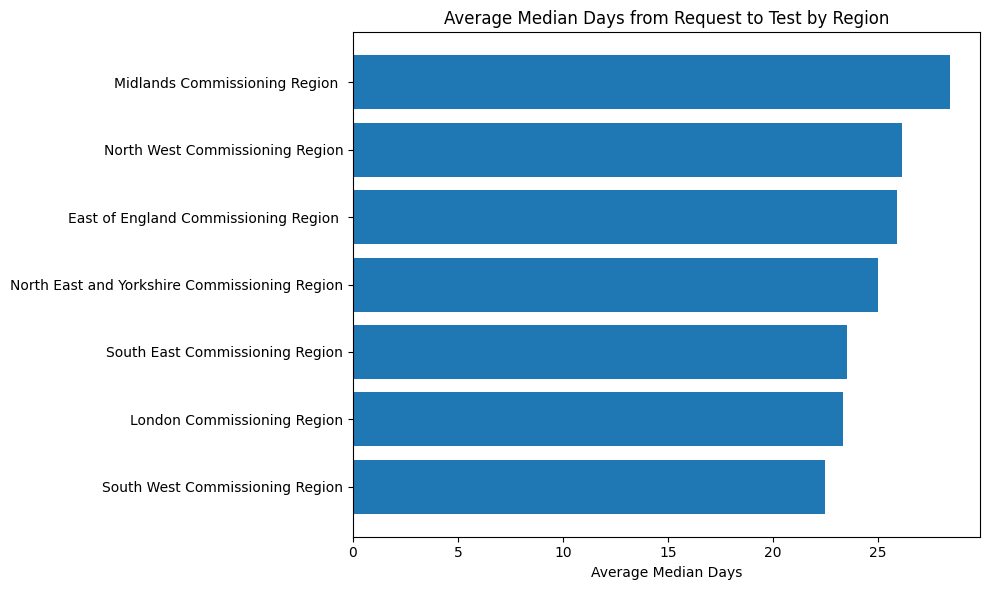

In [8]:
import matplotlib.pyplot as plt

# Step 1: Standardize column names for easier handling
df_clean = df_raw.rename(columns=lambda x: x.strip().replace(" ", "_").lower())

# Key columns of interest
provider_col = "provider_name"
region_col = "region_name"
median_col = "median_days_request_to_test"

# Convert median col to numeric
df_clean[median_col] = pd.to_numeric(df_clean[median_col], errors="coerce")

# Step 2: Build a provider -> region map using rows where region_name is known
provider_to_region = (
    df_clean.dropna(subset=[region_col])
    .groupby(provider_col)[region_col]
    .agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0])
    .to_dict()
)

# Step 3: Fill missing regions using provider map
df_clean[region_col] = df_clean.apply(
    lambda row: provider_to_region.get(row[provider_col], row[region_col]), axis=1
)

# Step 4: Compute average median days per region
avg_per_region = (
    df_clean.groupby(region_col)[median_col]
    .mean()
    .reset_index()
    .sort_values(median_col)
)

# Display the result
print(avg_per_region.head())

# Optional: save to CSV
avg_per_region.to_csv("average_median_days_per_region.csv", index=False)

# Step 5: Bar chart visualization
plt.figure(figsize=(10,6))
plt.barh(avg_per_region[region_col], avg_per_region[median_col])
plt.xlabel("Average Median Days")
plt.title("Average Median Days from Request to Test by Region")
plt.tight_layout()
plt.show()
